In [ ]:
#!pip install autograd
# In case, autograd is not installed.

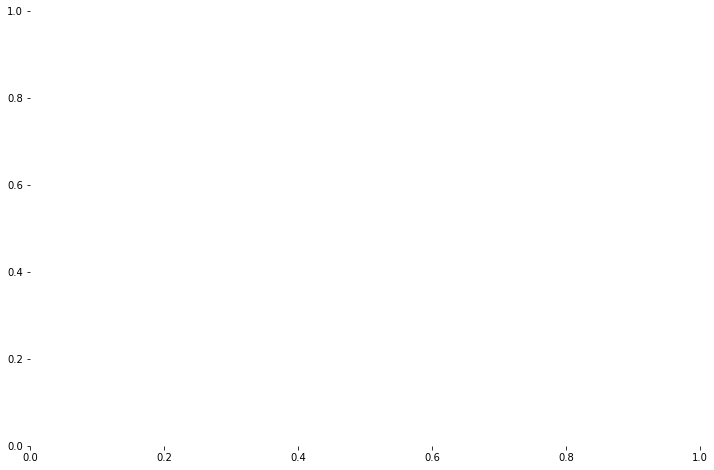

Log likelihood -660.0985496781634


C:\Users\e0335901\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
C:\Users\e0335901\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\numpy\numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
C:\Users\e0335901\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

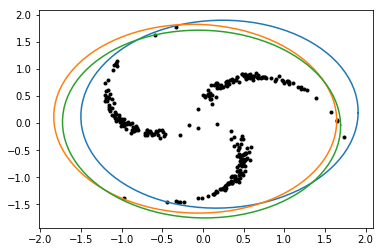

Log likelihood -630.2904820022579


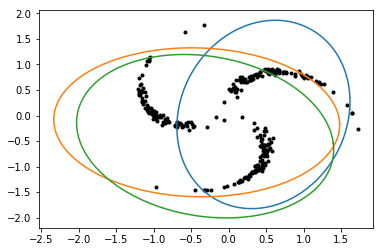

Log likelihood -612.470980514836


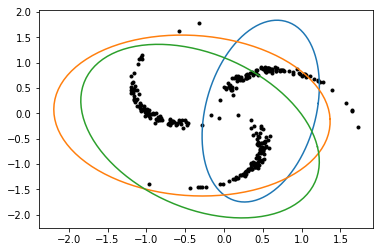

Log likelihood -584.9977762066972


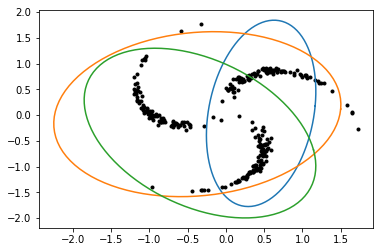

Log likelihood -578.9427782791629


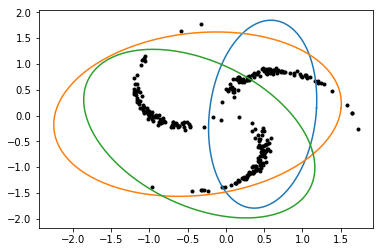

Log likelihood -570.7194882483076


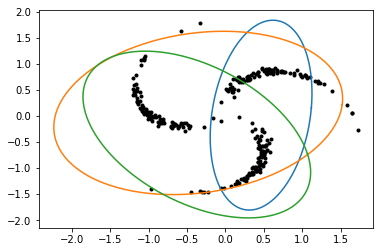

Log likelihood -565.4248221864775


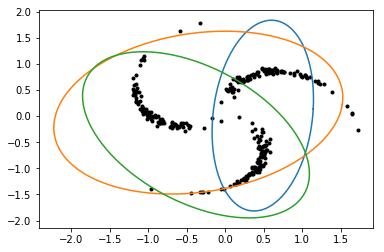

Log likelihood -558.3846331875591


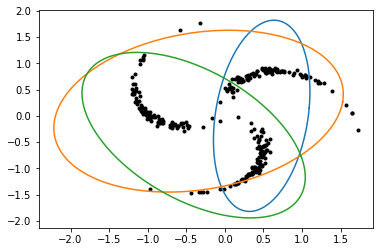

Log likelihood -553.6897291482388


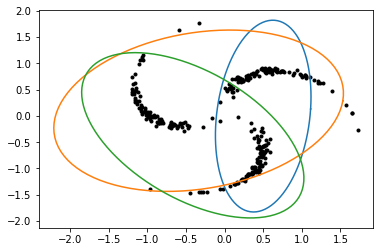

Log likelihood -548.4054643069835


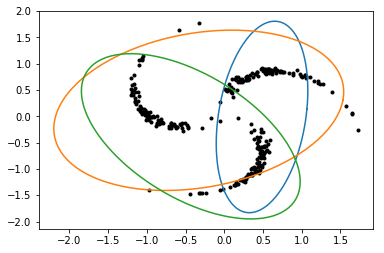

Log likelihood -538.3223423114997


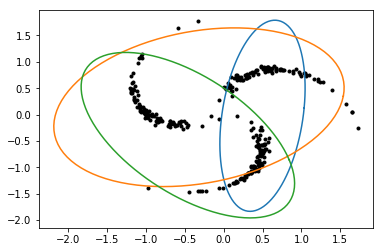

Log likelihood -519.129415962254


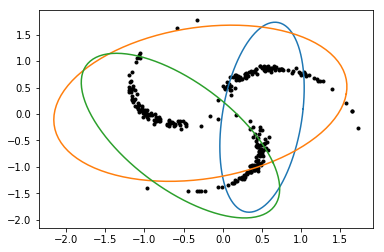

Log likelihood -501.4428035922998


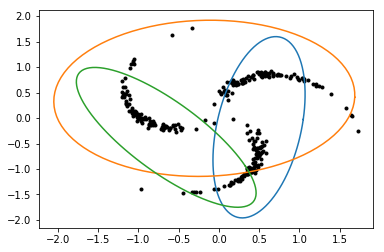

Log likelihood -490.8263502918435


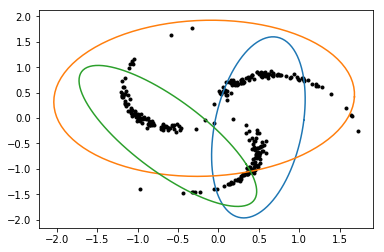

Log likelihood -471.62848460424374


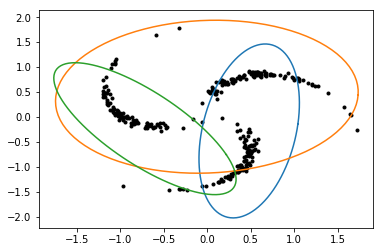

Log likelihood -448.056178535957


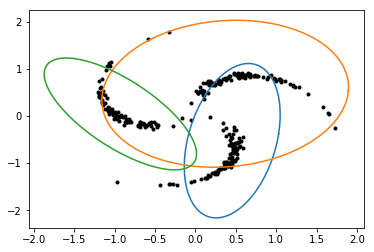

Log likelihood -435.2010483597796


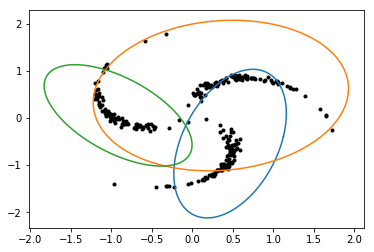

Log likelihood -423.2009132272404


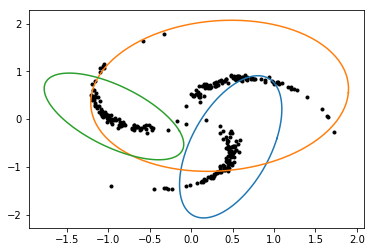

Log likelihood -411.53644331669886


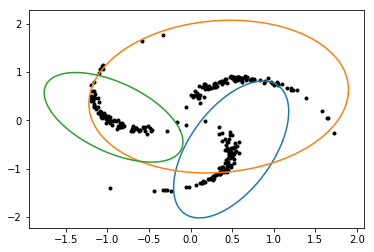

Log likelihood -392.74708268581776


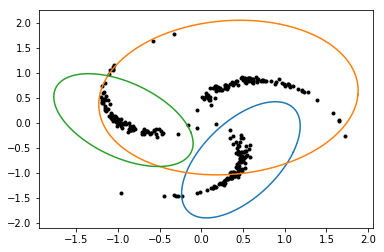

Log likelihood -381.31829550551527


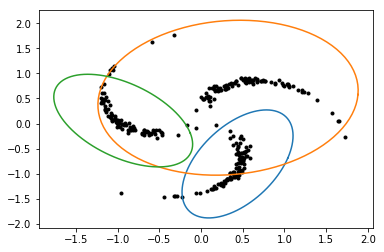

Log likelihood -374.5177984933083


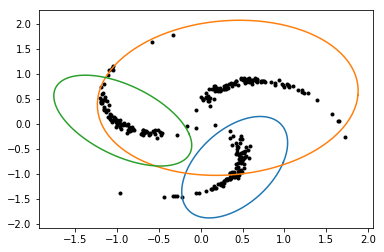

Log likelihood -372.45568237484144


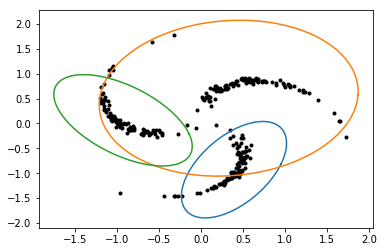

Log likelihood -370.0967976327652


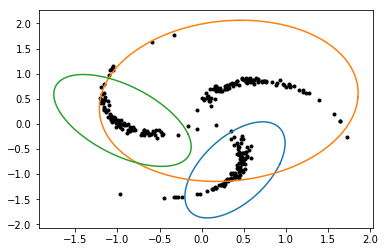

Log likelihood -369.96493463872565


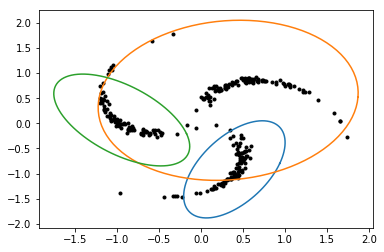

Log likelihood -369.87591072361954


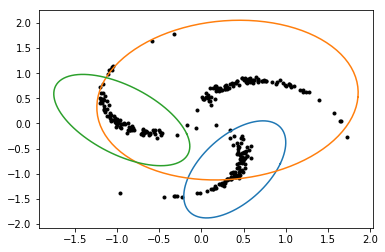

Log likelihood -369.860168901352


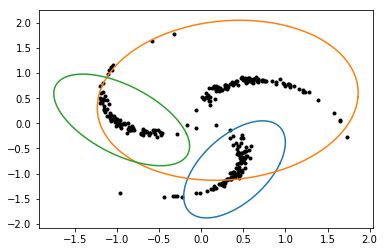

Log likelihood -369.85597878304196


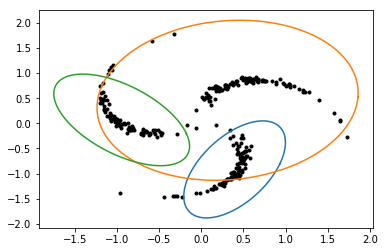

In [3]:
# %load gmm.py
"""Implements a Gaussian mixture model, in which parameters are fit using
   gradient descent.  This example runs on 2-dimensional data, but the model
   works on arbitrarily-high dimension."""

from __future__ import absolute_import
from __future__ import print_function

from __future__ import absolute_import
from __future__ import print_function
from builtins import range

from autograd.misc.optimizers import adam
from autograd.test_util import check_grads


import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, hessian_vector_product
from scipy.optimize import minimize
from autograd.scipy.misc import logsumexp
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.misc.flatten import flatten_func
from data import make_pinwheel


def mvn_logpdf(X, mu, cov_sqrt):
    return - 0.5 * np.log(np.linalg.det(2 * np.pi * cov_sqrt.T @ cov_sqrt)) \
           - 0.5 * np.sum(((X - mu) @ np.linalg.inv(cov_sqrt))**2, axis=1)

def init_gmm_params(num_components, D, scale, rs=npr.RandomState(0)):
    return {'log proportions': rs.randn(num_components) * scale,
            'means':           rs.randn(num_components, D) * scale,
            'lower triangles': np.zeros((num_components, D, D)) + np.eye(D)}

def log_normalize(x):
    return x - logsumexp(x)
#why log-normalize
def unpack_gmm_params(params):
    normalized_log_proportions = log_normalize(params['log proportions'])
    return normalized_log_proportions, params['means'], params['lower triangles']

def gmm_log_likelihood(params, data):
    cluster_lls = []
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        cov = np.dot(cov_sqrt.T, cov_sqrt)
        cluster_lls.append(log_proportion + mvn_logpdf(data, mean, cov))
    return np.sum(logsumexp(np.vstack(cluster_lls), axis=0))

def plot_ellipse(ax, mean, cov_sqrt, alpha, num_points=100):
    angles = np.linspace(0, 2*np.pi, num_points)
    circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
    cur_pts = mean + np.dot(circle_pts, cov_sqrt)
    plt.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)
    #plt.plot(range(10),range(10))

def plot_gaussian_mixture(params, ax):
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        alpha = np.minimum(1.0, np.exp(log_proportion) * 10)
        plot_ellipse(ax, mean, cov_sqrt, alpha)

if __name__ == '__main__':

    init_params = init_gmm_params(num_components=3, D=2, scale=0.1)

    data = make_pinwheel(radial_std=0.3, tangential_std=0.05, num_classes=3,
                         num_per_class=100, rate=0.4)

    def objective(params):
        return -gmm_log_likelihood(params, data)

    flattened_obj, unflatten, flattened_init_params =\
        flatten_func(objective, init_params)

    fig = plt.figure(figsize=(12,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)

    def callback(flattened_params):
        params = unflatten(flattened_params)
        print("Log likelihood {}".format(-objective(params)))
        ax.cla()
        #ax.plot(data[:, 0], data[:, 1], 'k.')
        plt.plot(data[:, 0], data[:, 1], 'k.')
        ax.set_xticks([])
        ax.set_yticks([])
        plot_gaussian_mixture(params, ax)
        plt.draw()
        #plt.plot(range(10),range(10))
        plt.pause(1.0/60.0)
        
        #input("Press [enter] to continue.")

    minimize(flattened_obj, flattened_init_params,
             jac=grad(flattened_obj),
             hessp=hessian_vector_product(flattened_obj),
             method='Newton-CG',tol=1e-3, callback=callback)
